In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from pathlib import Path

from pandas import testing as tm

import catboost as cb

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance

from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

import shap

import math

import os
import src

from dotenv import load_dotenv

In [3]:
pd.options.display.float_format = '{:,.2f}'.format

In [4]:
load_dotenv(override=True)

WORK_DIR = os.getenv("DATA_DIR")
FILE_NAME = 'df_work_test.zip'

In [5]:
filepath = f'..\\{WORK_DIR}\\{FILE_NAME}'

df1 = pd.read_csv(filepath, index_col=0, parse_dates=True)

In [6]:
df1.shape

(48117, 31)

In [36]:
def add_lags_inplace(df: pd.DataFrame, num_lags: int, for_ac: bool = True) -> None:

    if for_ac:
        for lag in range(1, num_lags + 1):
            lag_name = f'lag_{lag}'
            df[lag_name] = df1.groupby('ac')['Fe2+'].shift(lag)
    else:
        for lag in range(1, num_lags + 1):
            lag_name = f'lag_{lag}'
            df[lag_name] = df['Fe2+'].shift(lag)

    df.dropna(axis=0, inplace=True)

In [37]:
add_lags_inplace(df1, 3)

In [38]:
df1.shape

(48105, 34)

In [39]:
X = df1.drop(['Fe2+', 'ac'], axis=1)
X.reset_index(drop=True)
y = df1['Fe2+']
y.reset_index(drop=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [40]:
train_data = cb.Pool(X_train, y_train)
test_data = cb.Pool(X_test, y_test)

model_1 = cb.CatBoostRegressor(loss_function='RMSE', train_dir='..\\cache')
model_1.fit(train_data, plot=True, verbose=False, eval_set=test_data)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Метрики качества
RMSE: 0.5728
MAE: 0.1938
R2: 0.5933


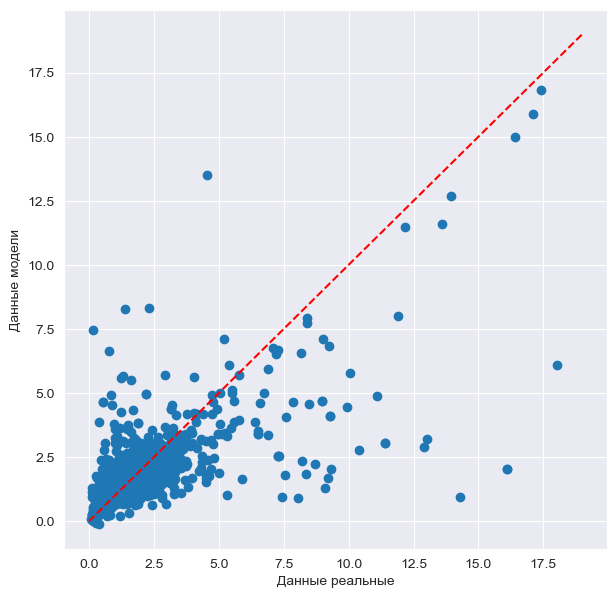

In [41]:
src.lib.model_score(model_1, X_test, y_test)

In [91]:
pred_cb_1 = model_1.predict(X_test)

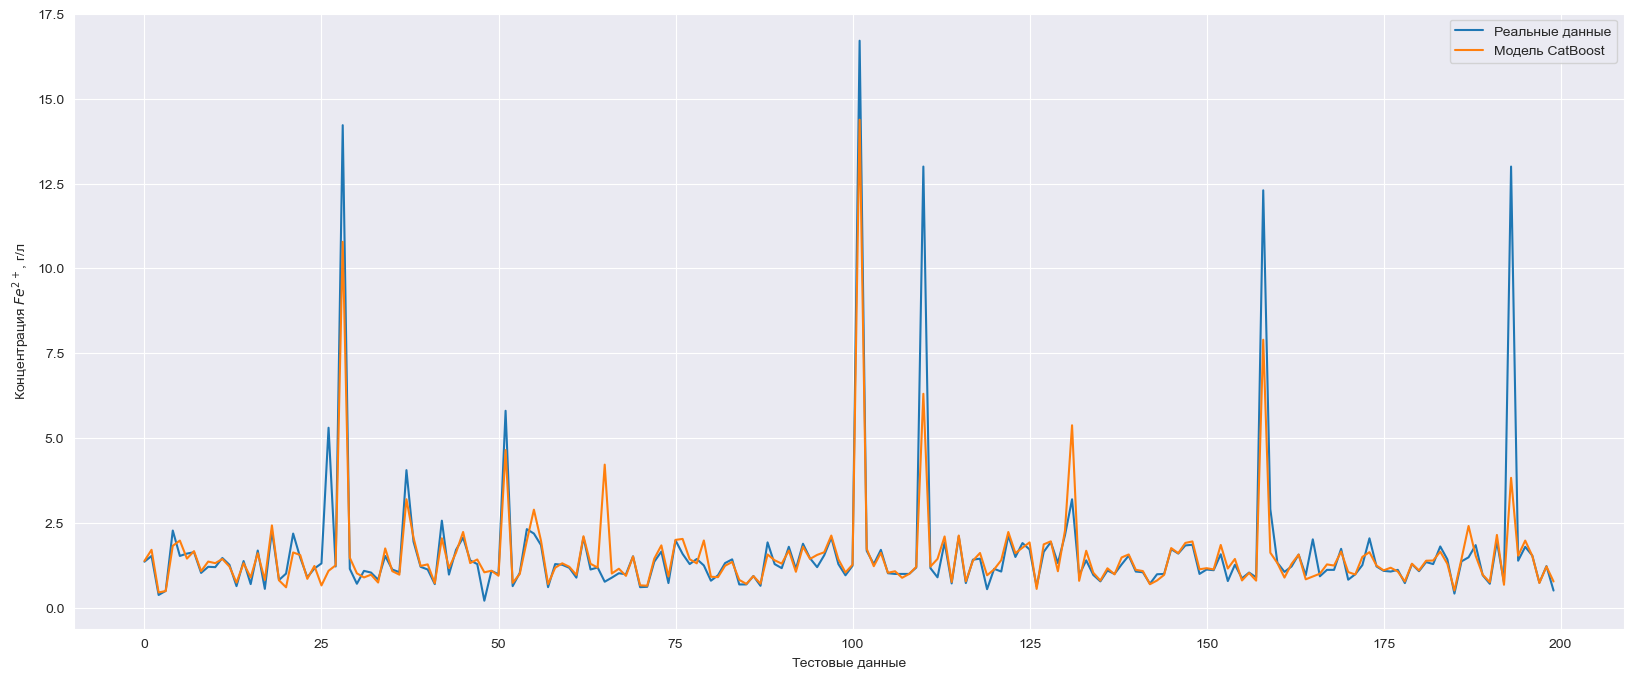

In [94]:
plt.figure(figsize=(20,8))

start = 0
end = 200

plt.plot(y_test.values[start:end], label='Реальные данные')
plt.plot(pred_cb_1[start:end], label='Модель CatBoost')

plt.ylabel("Концентрация $Fe^{2+}$, г/л")
plt.xlabel('Тестовые данные')

plt.legend()
plt.show();

## Оптимизация параметров

In [115]:
model_1.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'random_seed': 0,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'RMSE',
 'learning_rate': 0.07288800179958344,
 'score_function': '

In [14]:
grid = {'learning_rate': [0.03, 0.1, 0.2],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}

cat = cb.CatBoostRegressor(loss_function='RMSE', train_dir='..\\cache')

grid_search_result = cat.grid_search(grid, X=X_train, y=y_train, plot=True, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.6036829	test: 1.6021768	best: 1.6021768 (0)	total: 16.2ms	remaining: 16.2s
1:	learn: 1.5665138	test: 1.5652027	best: 1.5652027 (1)	total: 24.6ms	remaining: 12.3s
2:	learn: 1.5302854	test: 1.5292233	best: 1.5292233 (2)	total: 32.5ms	remaining: 10.8s
3:	learn: 1.4954411	test: 1.4947791	best: 1.4947791 (3)	total: 44ms	remaining: 11s
4:	learn: 1.4623076	test: 1.4618234	best: 1.4618234 (4)	total: 54.4ms	remaining: 10.8s
5:	learn: 1.4300312	test: 1.4295151	best: 1.4295151 (5)	total: 70.9ms	remaining: 11.7s
6:	learn: 1.3988609	test: 1.3986842	best: 1.3986842 (6)	total: 85.5ms	remaining: 12.1s
7:	learn: 1.3684768	test: 1.3685725	best: 1.3685725 (7)	total: 93.1ms	remaining: 11.5s
8:	learn: 1.3390827	test: 1.3391919	best: 1.3391919 (8)	total: 103ms	remaining: 11.4s
9:	learn: 1.3106162	test: 1.3108133	best: 1.3108133 (9)	total: 112ms	remaining: 11.1s
10:	learn: 1.2842329	test: 1.2845658	best: 1.2845658 (10)	total: 128ms	remaining: 11.5s
11:	learn: 1.2584166	test: 1.2589313	best: 1.258

KeyboardInterrupt: 

In [100]:
cat.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 7,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'random_seed': 0,
 'depth': 10,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'RMSE',
 'learning_rate': 0.20000000298023224,
 'score_function': 

In [101]:
cat.get_best_score()

{'learn': {'RMSE': 0.09624338342225607}}

Метрики качества
RMSE: 0.3785
MAE: 0.1446
R2: 0.7899


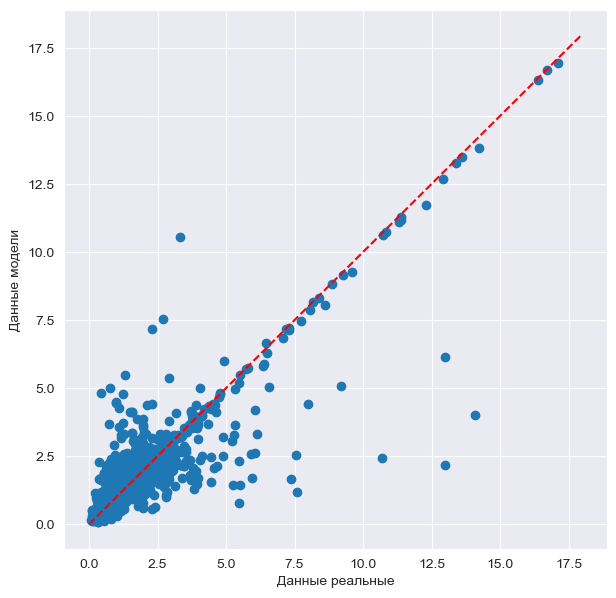

In [102]:
src.lib.model_score(cat, X_test, y_test)

In [103]:
pred_cb_cat = cat.predict(X_test)

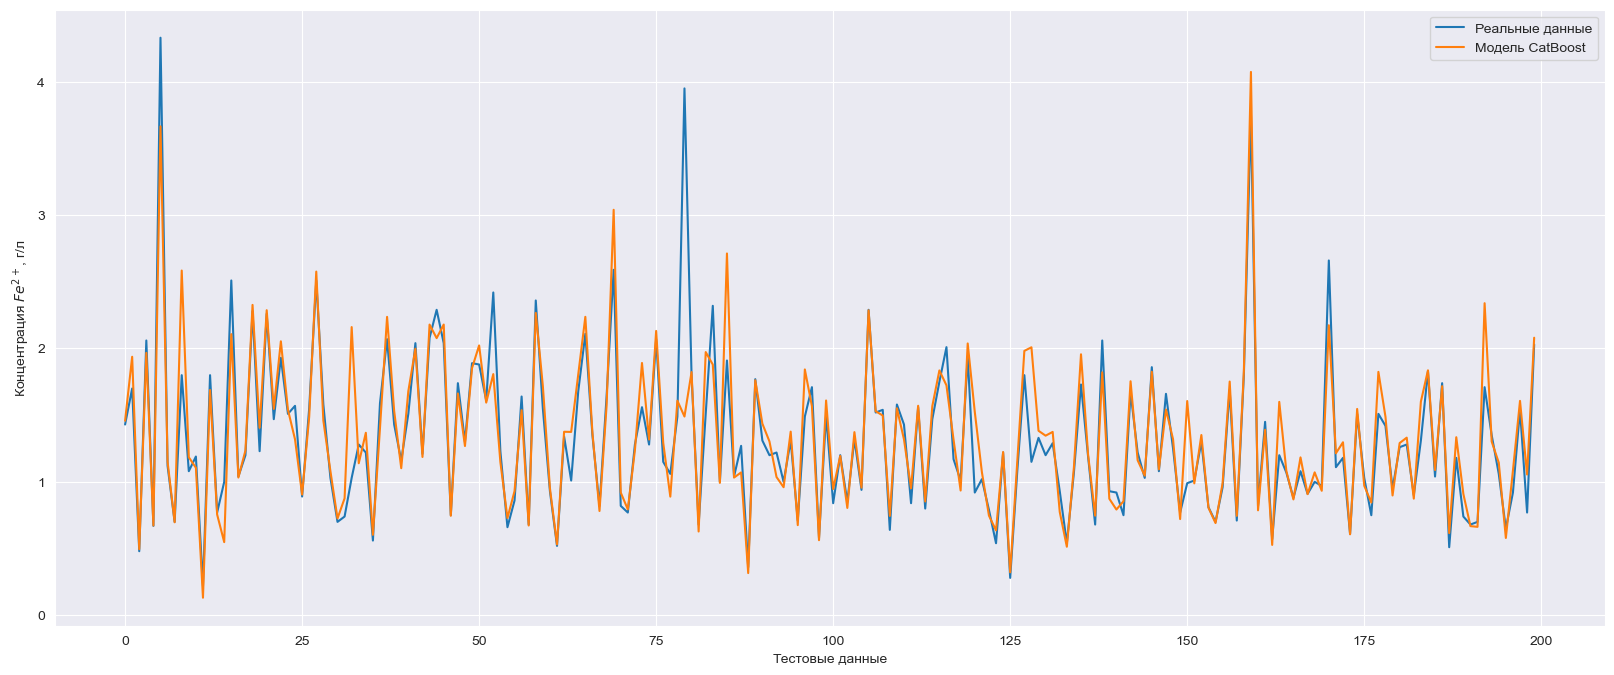

In [107]:
plt.figure(figsize=(20,8))

start = 1300
end = 1500

plt.plot(y_test.values[start:end], label='Реальные данные')
plt.plot(pred_cb_cat[start:end], label='Модель CatBoost')

plt.ylabel("Концентрация $Fe^{2+}$, г/л")
plt.xlabel('Тестовые данные')

plt.legend()
plt.show();

In [116]:
diff = y_test - pred_cb_cat
diff_base = y_test - pred_cb_1

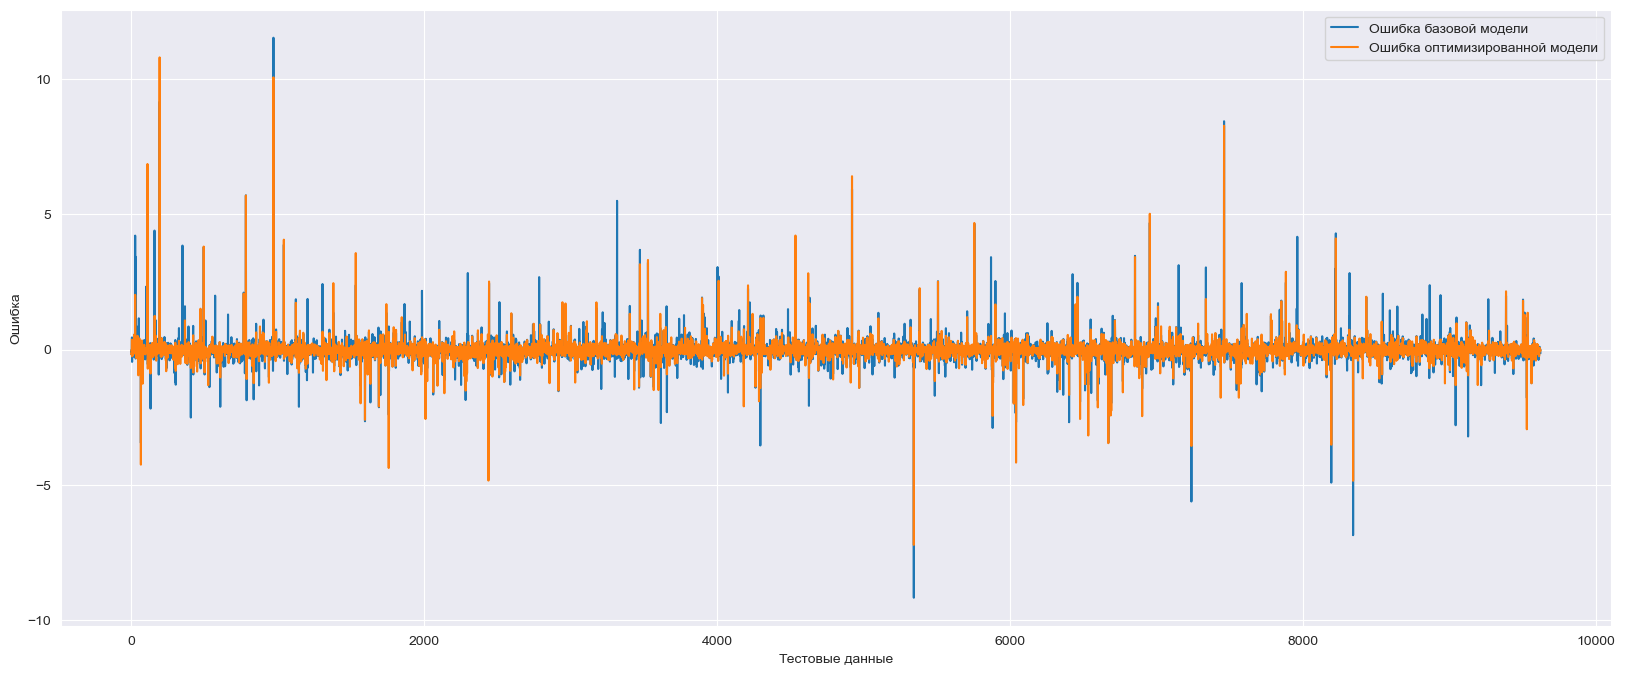

In [121]:
plt.figure(figsize=(20,8))

start = 0
end = 10000

plt.plot(diff_base.values[start:end], label='Ошибка базовой модели')
plt.plot(diff.values[start:end], label='Ошибка оптимизированной модели')

plt.ylabel("Ошибка")
plt.xlabel('Тестовые данные')

plt.legend()
plt.show();

Сохраним полученную модель

In [128]:
cat.save_model('model_1')